**Task VII: Equivariant quantum neural networks**

In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.
This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566. 
Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.
Train a QNN to solve the classification problem
Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.


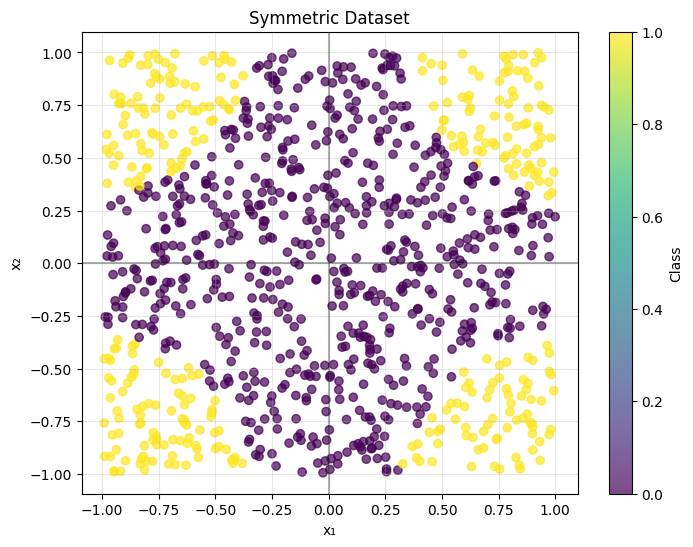

Training Simple QNN...
Epoch 0: Cost = 0.9505
Epoch 10: Cost = 0.9505
Epoch 20: Cost = 0.9505
Epoch 30: Cost = 0.9505
Epoch 40: Cost = 0.9505

Training Symmetric QNN...
Epoch 0: Cost = 0.7514
Epoch 10: Cost = 0.7514
Epoch 20: Cost = 0.7514
Epoch 30: Cost = 0.7514
Epoch 40: Cost = 0.7514

Model Results:
Simple QNN accuracy: 0.7500
Symmetric QNN accuracy: 0.6600
Simple QNN parameters: 8, Symmetric QNN parameters: 4


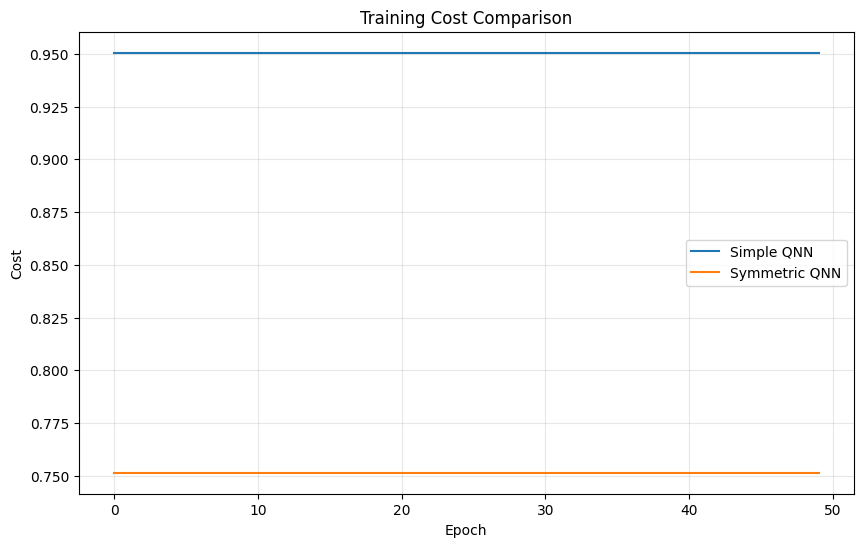

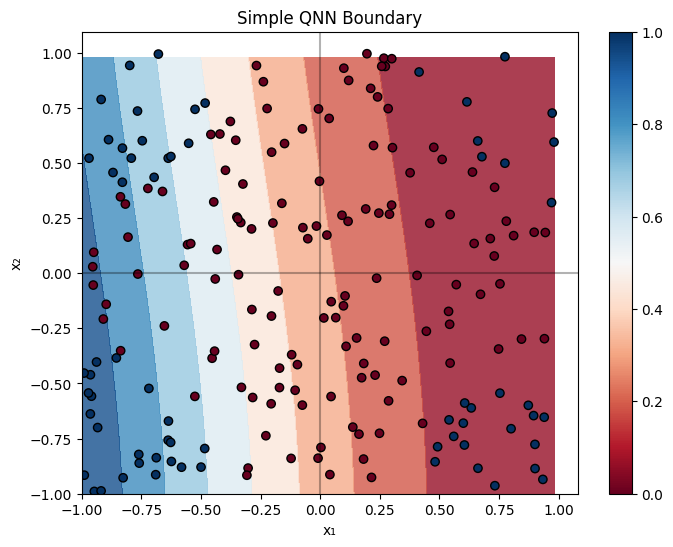

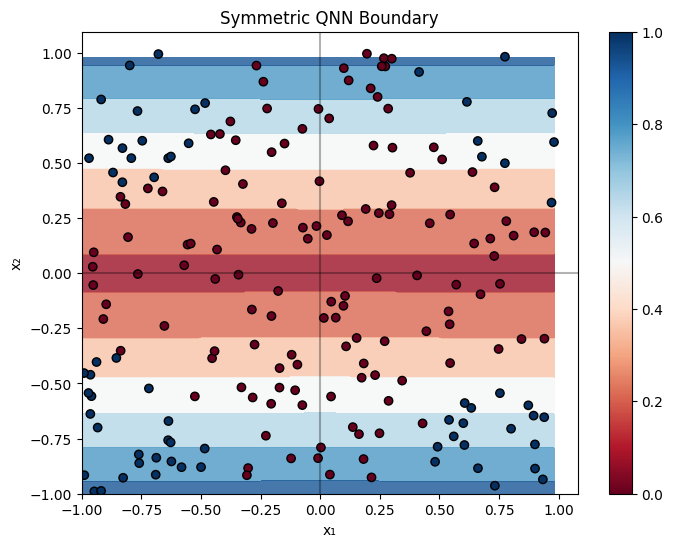

In [3]:
!pip install pennylane
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Set seed for consistent results
np.random.seed(42)

def create_symmetric_data(n_samples=1000):
    """Creates dataset with Z₂ × Z₂ symmetry."""
    # Random 2D points
    x1 = np.random.uniform(-1, 1, n_samples)
    x2 = np.random.uniform(-1, 1, n_samples)

    # Combine features
    inputs = np.column_stack((x1, x2))

    # Labels based on symmetry: 1 if |x₁ * x₂| > 0.3, else 0
    labels = (np.abs(x1 * x2) > 0.3).astype(int)

    return inputs, labels

# Generate data and split
inputs, labels = create_symmetric_data()
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.2, random_state=42)

# Show data
plt.figure(figsize=(8, 6))
plt.scatter(inputs[:, 0], inputs[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Symmetric Dataset')
plt.colorbar(label='Class')
plt.grid(alpha=0.3)
plt.show()

# Quantum device setup
n_qubits = 2
device = qml.device("default.qubit", wires=n_qubits)

# Simple QNN circuit
@qml.qnode(device)
def simple_qnn(features, weights):
    """Simple Quantum Neural Network circuit."""
    weights = weights.reshape(2, 2, 2) # Reshape weights

    qml.RY(features[0], wires=0) # Input encoding
    qml.RY(features[1], wires=1)

    for layer in range(2): # Layers of gates
        qml.RY(weights[layer, 0, 0], wires=0)
        qml.RY(weights[layer, 0, 1], wires=1)

        qml.RZ(weights[layer, 1, 0], wires=0)
        qml.RZ(weights[layer, 1, 1], wires=1)

        qml.CNOT(wires=[0, 1]) # Entanglement

    return qml.expval(qml.PauliZ(0)) # Expectation value

# Symmetric QNN circuit
@qml.qnode(device)
def symmetric_qnn(features, weights):
    """Symmetric Equivariant QNN circuit."""
    weights = weights.reshape(2, 2) # Reshape weights

    qml.RY(np.abs(features[0]), wires=0) # Symmetric input encoding
    qml.RY(np.abs(features[1]), wires=1)

    for layer in range(2): # Symmetric layers
        qml.RY(weights[layer, 0], wires=0) # Shared parameters
        qml.RY(weights[layer, 0], wires=1)

        qml.RZ(weights[layer, 1], wires=0) # Shared parameters
        qml.RZ(weights[layer, 1], wires=1)

        qml.CNOT(wires=[0, 1]) # Symmetric entanglement
        qml.CNOT(wires=[1, 0])

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)) # Symmetric measurement

# Cost for simple QNN
def simple_cost(weights, inputs, labels):
    """Cost function for simple QNN."""
    encoded_labels = 2 * labels - 1 # Labels to {-1,1}
    predictions = np.array([simple_qnn(x, weights) for x in inputs]) # Predictions
    return np.mean((predictions - encoded_labels) ** 2) # MSE Loss

# Cost for symmetric QNN
def symmetric_cost(weights, inputs, labels):
    """Cost function for symmetric QNN."""
    encoded_labels = 2 * labels - 1 # Labels to {-1,1}
    predictions = np.array([symmetric_qnn(x, weights) for x in inputs]) # Predictions
    return np.mean((predictions - encoded_labels) ** 2) # MSE Loss

# Initialize weights
np.random.seed(42)
simple_weights = np.random.uniform(0, 2*np.pi, 8) # Simple QNN weights
symmetric_weights = np.random.uniform(0, 2*np.pi, 4) # Symmetric QNN weights

# Training function
def train_model(cost_func, weights, inputs, labels, rate=0.1, epochs=100):
    """Trains a model with given cost, weights, data, and settings."""
    opt = qml.GradientDescentOptimizer(rate) # Optimizer

    current_weights = weights.copy() # Weights to train
    cost_history = [] # Track cost

    for epoch in range(epochs):
        current_weights = opt.step(lambda w: cost_func(w, inputs, labels), current_weights) # Update weights
        current_cost = cost_func(current_weights, inputs, labels) # Cost value
        cost_history.append(current_cost) # Store cost

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Cost = {current_cost:.4f}")

    return current_weights, cost_history

# Use smaller data for faster training
train_inputs_subset = train_inputs[:50]
train_labels_subset = train_labels[:50]

# Train simple QNN
print("Training Simple QNN...")
trained_simple_weights, simple_cost_history = train_model(
    simple_cost, simple_weights, train_inputs_subset, train_labels_subset,
    rate=0.03, epochs=50
)

# Train symmetric QNN
print("\nTraining Symmetric QNN...")
trained_symmetric_weights, symmetric_cost_history = train_model(
    symmetric_cost, symmetric_weights, train_inputs_subset, train_labels_subset,
    rate=0.03, epochs=50
)

# Evaluate simple QNN
def evaluate_simple_model(weights, inputs, labels):
    """Evaluates simple QNN accuracy."""
    predictions = np.array([simple_qnn(x, weights) for x in inputs])
    binary_preds = (predictions > 0).astype(int) # To binary class
    return accuracy_score(labels, binary_preds) # Accuracy

# Evaluate symmetric QNN
def evaluate_symmetric_model(weights, inputs, labels):
    """Evaluates symmetric QNN accuracy."""
    predictions = np.array([symmetric_qnn(x, weights) for x in inputs])
    binary_preds = (predictions > 0).astype(int) # To binary class
    return accuracy_score(labels, binary_preds) # Accuracy

# Use subset for faster evaluation
test_inputs_subset = test_inputs[:100]
test_labels_subset = test_labels[:100]

simple_accuracy = evaluate_simple_model(trained_simple_weights, test_inputs_subset, test_labels_subset)
symmetric_accuracy = evaluate_symmetric_model(trained_symmetric_weights, test_inputs_subset, test_labels_subset)

print(f"\nModel Results:")
print(f"Simple QNN accuracy: {simple_accuracy:.4f}")
print(f"Symmetric QNN accuracy: {symmetric_accuracy:.4f}")
print(f"Simple QNN parameters: {simple_weights.size}, Symmetric QNN parameters: {symmetric_weights.size}")

# Plot costs
plt.figure(figsize=(10, 6))
plt.plot(simple_cost_history, label='Simple QNN')
plt.plot(symmetric_cost_history, label='Symmetric QNN')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Cost Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot boundaries
def plot_boundary(model_type, weights, title):
    """Plots decision boundary for given model."""
    x_min, x_max = -1, 1 # Grid range
    y_min, y_max = -1, 1
    step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # Create grid

    Z = np.zeros(xx.shape) # Predictions on grid
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            features = np.array([xx[i, j], yy[i, j]])
            if model_type == "simple":
                prediction = simple_qnn(features, weights)
            else:
                prediction = symmetric_qnn(features, weights)
            Z[i, j] = prediction

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu) # Boundary colors

    plt.scatter(test_inputs[:, 0], test_inputs[:, 1], c=test_labels, cmap=plt.cm.RdBu, edgecolors='k') # Test data
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title(title)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.colorbar()
    plt.show()

# Show decision boundaries
plot_boundary("simple", trained_simple_weights, "Simple QNN Boundary")
plot_boundary("symmetric", trained_symmetric_weights, "Symmetric QNN Boundary")